In [1]:
'''
In this implementation, we consider 6 inputs to the neural network namely,cos(th1),sin(th1),cos(th2),sin(th2),dth1,dth2
The output from the system are the Q values for each of the 3 actions taken
We considered the actions available as [-Mval, 0, Mval]. In the code, Mval is considered as 2.0 
which seems to give most optimum performance. (I also played around with Mval=1,3,5)
In addition, reward is defined in acrobot.py such that, 
    reward = -self.L1*np.cos(s_new[0]) - self.L2*np.cos(s_new[0] + s_new[1])
    if(reward>0): (inverted position more weights provided so that neural network recognizes this as optimal)
        reward = 3*reward
In the neural network DQN framework, I considered 4 layers such that the input to first linear layer is 6 (input size). 
I also played around witb the number of nodes in each Linear layer. The current configuration has 32, 64, 128
I tuned the batch size, i.e., 32, 64, 128 and 256. Current configuration has 256 as batch size
The number of episodes per each layer are considered as 500 (also tried 50, 100, 150) 
The number of episodes are 50 (also tried 10, 20 and 30)
I considered an exponential decay in the epsilon of our epsilon-greedy algorithm
so that at the start of each episode I take an action randomly, 
and as the iterations pass, I rely more on the learnt Q to generate optimal action
Initially, I also considered a constant epsilon of 0.1 but this exponential decay seemed to perform better
RMSprop based objective function is considered for optimization 
Policy (behavior) network is updated at each step of episode whereas target network is updated every 10 episodes 
'''

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from acrobot.acrobot import AcroEnvNew

### Environment of acrobot
env = gym.make('MyAcrobot-v2').unwrapped
device = torch.device("cpu") ## Using CPU

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
# 2-6:30am: work on hw for AE-598 RL
# 6:30-7:45am: practice for presentation
# 7:45-8:15am: Get ready and go down with laptop for changes
## Wed night: Work on presentation practice and submit hw after discussing with akshay. 

### Architecture of the Deep Q-neural network 
### Linear layer is considered without batch normalization
### Number of units in each layer and the number of layers are hyperparameters
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear( 6, 32)
        self.lin2 = nn.Linear(32, 64)
        self.lin3 = nn.Linear(64, 128)
        self.head = nn.Linear(128,  3)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        return self.head(x.view(x.size(0), -1))

In [3]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
### Initializing thte policy and target neural networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

### Defining the optimizer as RMSprop
optimizer = torch.optim.RMSprop(policy_net.parameters())

### get action state based on the e-greedy algorithm
EPS = 0.1 
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 120

def get_action(state, steps_done):
    sample = random.random()
    eps_th = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    #print('eps_th: ', eps_th)
    if sample > eps_th: #EPS:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(3)]], device=device, dtype=torch.long)

In [5]:
### This training model is referenced from the blog on reinforcement learning for cartpole 
### Reference: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
### Comments are added by me and the code has been thoroughly analyzed
BATCH_SIZE = 256
GAMMA = 0.999
def train_model():
    ### If length of memory is less than batch_size then we skip the optimization it we have enough samples
    if len(memory) < BATCH_SIZE:
        #print('No enough samples! ')
        return
    ### Else we randomly choose a BTACH_SIZE number of samples 
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat(batch.next_state) #[s for s in batch.next_state if s is not None])
    #print('non_final_mask: ', non_final_mask)
    #print('non_final_next_states: ', non_final_next_states)
                    
    #print('BEFORE batch_state: ', batch.state)
    #print('BEFORE batch_action: ', batch.action)
    #print('BEFORE batch_reward: ', batch.reward)
    
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch = torch.cat(batch.state)
    #print('AFTER batch_action: ', action_batch)
    #print('AFTER batch_reward: ', reward_batch)
    #print('AFTER batch_state: ', state_batch)
    
    # Compute the policy Q(s, a), thereafter we select the corresponding action items
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    #print('state_action_values: ', state_action_values)
    
    # Compute next state values
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    
    # Compute the expected Q values for the next state
    expected_state_action_values = reward_batch + (GAMMA * next_state_values) 

    ### Evaluate objective function based on huber loss-> 
    ### acts as mean squared loss, i.e., (\delta)^2/2 if |\delta|<1 
    ### acts as mean absolute loss, i.e., |\delta|-0.5 elsewhere
    loss = F.smooth_l1_loss( state_action_values, expected_state_action_values.unsqueeze(1) )

    ### Optimize the model using SGD implementation -> especially RMSprop
    optimizer.zero_grad()
    loss.backward()
    
    ### Update the training model based on the optimization carried out
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [6]:
### Initialize the no of episodes and no of iterations in each episode
no_eps = 50 #20
t_eps = 500
TARGET_UPDATE = 10

## Initialize the memory matrix-> indicates the number of samples it can store in buffer
### Indicate how soon it forgets the observed data
memory = ReplayMemory(10000)

### Initialize storage arrays
store_meas = {}
store_state = {}
store_action = {}
store_reward = {}
total_reward = []

### Random seed for the action space
env.seed(100)

for i_episode in range(no_eps):
    store_meas[str(i_episode)] = []
    store_state[str(i_episode)] = []
    store_action[str(i_episode)] = []
    store_reward[str(i_episode)] = []

    ### Reset at the start of each episode 
    init_out, init_state = env.reset()
    next_out = torch.tensor([init_out], device=device, dtype=torch.float)
    #print('After reset: ', init_state, next_out)
    
    ### Constant iterations are executed for each episode
    ### Aim is to maximize the rewards obtained in each episode
    for t in range(t_eps):
        
        env.render()
        ### This is random action -> 
        #action = torch.tensor([[1]], device=device, dtype=torch.long) #env.action_space.sample()
        
        ### e-greedy algorithm is executed 
        action = get_action(next_out, t)
        
        store_action[str(i_episode)].append(action)

        #### Get the measurements from the system and the corresponding rewards
        next_st, reward, done, info = env.step(action)
        reward = torch.tensor([reward], device=device)
        cur_out = torch.tensor([info['cur_out']], device=device, dtype=torch.float) 
        next_out = torch.tensor([info['next_out']], device=device, dtype=torch.float)
        #print('reward: ', reward)
        #print('cur_output: ', cur_out)
        #print('next_output: ', next_out)
        
        ### info['state'] indicates the state after the execution of action
        store_state[str(i_episode)].append(next_st)
        store_meas[str(i_episode)].append(next_out)
        store_reward[str(i_episode)].append(reward)
        
        ### Store the transition array for current instant in memory
        ### What was the state at current instant, what action was give, what state it reached 
        ### and then associated reward
        memory.push(cur_out, action, next_out, reward)

        ### Train the neural network in this step by performing SGD based optimization 
        train_model()

    
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        print('Target network updated at: ', i_episode)
        target_net.load_state_dict(policy_net.state_dict())

    total_reward.append(sum(store_reward[str(i_episode)]))

env.close()

Target network updated at:  0
Target network updated at:  10
Target network updated at:  20
Target network updated at:  30
Target network updated at:  40


Text(0.5,0,'Episode')

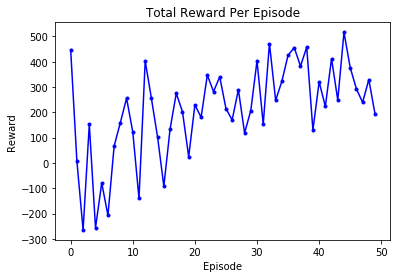

In [7]:
plt.plot(total_reward, 'b')
plt.plot(total_reward, 'b.')
plt.ylabel('Reward')
plt.title('Total Reward Per Episode')
plt.xlabel('Episode')

idx:  49


Text(0.5,1,'Reward obtained at each instant')

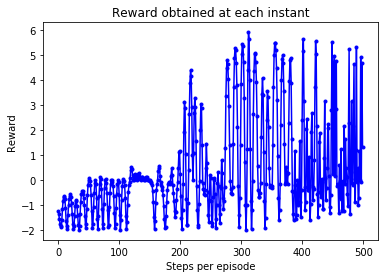

In [8]:
idx = no_eps-1 #random.randint(0,no_eps-1)
print('idx: ', idx)
plt.plot(store_reward[str(idx)], 'b')
plt.plot(store_reward[str(idx)], 'b.')
plt.xlabel('Steps per episode')
plt.ylabel('Reward')
plt.title('Reward obtained at each instant')

Text(0.5,0,'Iterations')

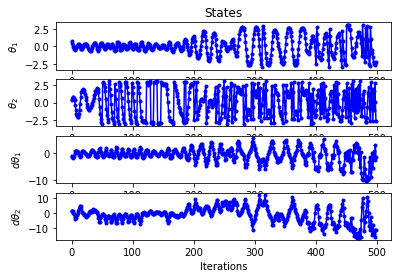

In [9]:
plt.subplot(411)
plt.plot(np.transpose(store_state[str(idx)])[0], 'b')
plt.plot(np.transpose(store_state[str(idx)])[0], 'b.')
plt.ylabel(r'$\theta_1$')
plt.title('States')
plt.subplot(412)
plt.plot(np.transpose(store_state[str(idx)])[1], 'b')
plt.plot(np.transpose(store_state[str(idx)])[1], 'b.')
plt.ylabel(r'$\theta_2$')
plt.subplot(413)
plt.plot(np.transpose(store_state[str(idx)])[2], 'b')
plt.plot(np.transpose(store_state[str(idx)])[2], 'b.')
plt.ylabel(r'$d\theta_1$')
plt.subplot(414)
plt.plot(np.transpose(store_state[str(idx)])[3], 'b')
plt.plot(np.transpose(store_state[str(idx)])[3], 'b.')
plt.ylabel(r'$d\theta_2$')
plt.xlabel('Iterations')